### Install python modules
Install on SageMaker the necesary modules for this notebook to work

In [1]:
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip
!pip install pytube
!pip install seaborn
!pip install smart_open
!pip install Unidecode
!pip install python-Levenshtein

     |████████████████████████████████| 41 kB 786 kB/s  eta 0:00:01
     |████████████████████████████████| 119 kB 25.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109630 sha256=de7e13f320d5882b9638097c7061e2ddced2513baa29820169a8431d77d04867
  Stored in directory: /home/ec2-user/.cache/pip/wheels/05/12/87/d479d6a8f92130cd8b27e331cc433bb28dda9c20e57f0b1ab2
Successfully built smart-open
     |████████████████████████████████| 241 kB 26.3 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 7.1 MB/s  eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp36-cp36m-linux_x86_64.whl size=155943 sha256=e511d9c09f07bf620026e50d8fe5f86780ebab96614d55419fe5be607dc7ffc6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4a/a4/bf/d761b0899395c75fa76d003d607b3869ee47f5035b8afc30a2
Successfully built python-Levenshtein


### Import modules

In [171]:
import pandas as pd
#from adaptors import youtube2df, aws2df, upload_yt_file, get_folder_list, vocabulary_shuffle, 
import matplotlib.pyplot as plt
import seaborn as sns
from adaptors import *
from pytube import YouTube
import boto3
from botocore.exceptions import ClientError
import sys, os
import numpy as np
import Levenshtein as lv

print('Import done correctly!')

Import done correctly!


Define a YouTube video URL

In [2]:
url = 'https://youtu.be/eEOhx-u9Z2k'
#url = 'https://youtu.be/Mxv9AM397Y8'

# Get video object
yt = YouTube(url)
print(yt)

### Download videos from Youtube
We'll download videos from youtube, save them into an S3 bucket that triggers a transcribe job (with or without IPA vocabulary)

In [ ]:
# Get the tittle and replace spaces with underscore
yt_title = yt.title.replace(' ', '_')
    
# Download the video to tmp folder and save the output name to file_name
file_name = yt.streams.first().download(output_path="/tmp" ,filename=yt_title)


In [ ]:
# Returns True if file was uploaded, else False
upload_yt_file(file_name)

### Download captions from the YouTube video
From the said YouTube video we'll get the 'a.es' caption if exist 

In [ ]:
if yt.captions.get_by_language_code('es-419'):
    code = 'es-419'
    caption = yt.captions.get_by_language_code('es-419')
    yt_caption = caption.generate_srt_captions()
    yt_title = yt.title.replace(' ', '_')
    with open(f'/tmp/{yt_title}_{code}.txt', 'a') as f:
        f.write(yt_caption)
else:
    print('This caption doesn\'t exist')
    print('You can use one of the following captions: \n', yt.captions.all())

### Upload the caption to S3

In [ ]:
upload_yt_file(f'/tmp/{yt_title}_{code}.txt', object_name=f'levenshteinTests/ytCaptions/{yt_title}.txt')

# Generate Levenshtein score 
To generate the Levenshtein score, we use the Levenshtein distance and substract 1 to generate a metric

### Transform all the data to DataFrames
Transform AWS RAW (without custom vocabulary) Transcribe JSON output to DataFrame  

In [111]:
aws_transcribe = aws2df('s3://awstranscribe-tests/levenshteinTests/RAW/utubeVideos/Un_show_FALLIDO_-_Mini_Especial_Rancagua__Edo_Caroe.json')
aws_transcribe.head()

,start,end,transcript
0,0.04,0.51,La
1,0.51,1.03,Fallida
2,1.03,1.73,actuación
3,1.74,1.92,en
4,1.92,3.08,Rancagua


Transform AWS IPA (with custom vocabulary) Transcribe JSON to DataFrame

In [112]:
aws_transcribe_ipa = aws2df('s3://awstranscribe-tests/levenshteinTests/IPA/utubeVideos/Un_show_FALLIDO_-_Mini_Especial_Rancagua__Edo_Caroe.json')
aws_transcribe_ipa.head()

,start,end,transcript
0,0.04,0.51,La
1,0.51,1.03,Fallida
2,1.03,1.73,actuación
3,1.74,1.92,en
4,1.92,3.08,Rancagua


Transform custom YouTube caption to DataFrame

In [113]:
yt_transcribe = youtube2df('s3://awstranscribe-tests/levenshteinTests/ytCaptions/Un_show_FALLIDO_-_Mini_Especial_Rancagua_|_Edo_Caroe.txt')
yt_transcribe.head()

,orig_index,start,end,transcript
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!"
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>"
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>"
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>"
4,5,126.916,128.416,"<b>Ay, weón...</b>"


Transform aut-generated YouTube caption to DataFrame

In [114]:
yt_transcribe_raw = youtube2df('s3://awstranscribe-tests/levenshteinTests/ytCaptions/Un_show_FALLIDO_-_Mini_Especial_Rancagua___Edo_Caroe_RAW.txt')
yt_transcribe_raw.head()

,orig_index,start,end,transcript
0,1,0.00,5.43,la fallida actuación en rancagua 1
1,2,3.27,6.87,problema de este lugar web sin duda uno
2,3,5.43,9.09,de los shows más raros de la gira moto
3,4,6.87,15.99,al sur y probablemente uno de los
4,5,9.09,18.15,mejores pero bueno los shows de la gira


### Wrapping all together

Create new column on yt_transcribe DataFrame, adding the AWS RAW Transcription

In [115]:
yt_transcribe['aws_transcript'] = compress(yt_transcribe, aws_transcribe)
yt_transcribe.head()

,orig_index,start,end,transcript,aws_transcript
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!",lo puro problema este lugar Bueno lo puro prob...
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>",voy a tributar ahora Cuidado voy a tributar ah...
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>",puedes Todo esto va a pasar puedes Todo esto v...
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>",Toma Julia Toma Julia
4,5,126.916,128.416,"<b>Ay, weón...</b>",Hay Hay


Create new column on yt_transcribe DataFrame, adding the AWS IPA Transcription

In [116]:
yt_transcribe['aws_transcript_ipa'] = compress(yt_transcribe, aws_transcribe_ipa)
yt_transcribe.head()

,orig_index,start,end,transcript,aws_transcript,aws_transcript_ipa
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!",lo puro problema este lugar Bueno lo puro prob...,lo puro problema este lugar Bueno lo puro prob...
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>",voy a tributar ahora Cuidado voy a tributar ah...,voy a tributar ahora Cuidado voy a tributar ah...
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>",puedes Todo esto va a pasar puedes Todo esto v...,puedes Todo esto va a pasar puedes Todo esto v...
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>",Toma Julia Toma Julia,Tomas culiao Tomas culiao
4,5,126.916,128.416,"<b>Ay, weón...</b>",Hay Hay,hay hay


Show the final form of the yt_transcribe DataFrame

In [117]:
yt_transcribe.head()

,orig_index,start,end,transcript,aws_transcript,aws_transcript_ipa
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!",lo puro problema este lugar Bueno lo puro prob...,lo puro problema este lugar Bueno lo puro prob...
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>",voy a tributar ahora Cuidado voy a tributar ah...,voy a tributar ahora Cuidado voy a tributar ah...
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>",puedes Todo esto va a pasar puedes Todo esto v...,puedes Todo esto va a pasar puedes Todo esto v...
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>",Toma Julia Toma Julia,Tomas culiao Tomas culiao
4,5,126.916,128.416,"<b>Ay, weón...</b>",Hay Hay,hay hay


### Generate the Levenshtein score

Generate the score and create a DataFrame to show as boxplot

In [118]:
yt_transcribe['lv_score_yt_to_raw'] = lv_score(yt_transcribe['transcript'], yt_transcribe['aws_transcript'])
yt_transcribe['lv_score_yt_to_ipa'] = lv_score(yt_transcribe['transcript'], yt_transcribe['aws_transcript_ipa'])
ipa_tuple = [('real_to_ipa', a_score) for a_score in yt_transcribe['lv_score_yt_to_ipa']]
raw_tuple = [('real_to_raw', a_score) for a_score in yt_transcribe['lv_score_yt_to_raw']]
df =  pd.DataFrame(ipa_tuple + raw_tuple, columns = ['model', 'score'])


### Means

In [119]:
yt_transcribe['lv_score_yt_to_raw'].mean()

0.06847326469652637

In [120]:
yt_transcribe['lv_score_yt_to_ipa'].mean()

0.07340970455066548

In [121]:
yt_transcribe['lv_score_yt_to_ipa'].mean() / yt_transcribe['lv_score_yt_to_raw'].mean()

1.0720929530089944

Show the score as boxplot

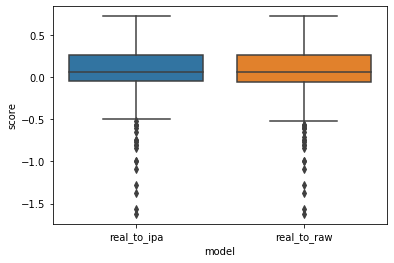

In [20]:
sns.boxplot(data=df, x='model', y='score')
plt.show()

# IPA Shuffle Dictionary
From our universe of 124 words we'll randomly select N number of words and create a new dictionary: IPA_Shuffle

In [22]:
vocabulary_shuffle()

Updating Vocab: IPA_Shuffle
 {'VocabularyName': 'IPA_Shuffle', 'LanguageCode': 'es-ES', 'VocabularyState': 'PENDING', 'ResponseMetadata': {'RequestId': '090cfeac-e0d5-485c-a9b7-7f25a8ce2bb8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Thu, 04 Mar 2021 22:07:10 GMT', 'x-amzn-requestid': '090cfeac-e0d5-485c-a9b7-7f25a8ce2bb8', 'content-length': '83', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


# Playin with Data

In [ ]:
aws_transcribe = aws2df('s3://awstranscribe-tests/levenshteinTests/RAW/utubeVideos/Un_show_FALLIDO_-_Mini_Especial_Rancagua__Edo_Caroe.json')
aws_transcribe.head()

In [162]:
data_loc = get_folder_list(key='levenshteinTests/RAW/')
videos = [i for i in data_loc if i.find('deo_0_') != -1]

In [179]:
video_reference = 's3://awstranscribe-tests/levenshteinTests/RAW/deo_0_16kHz_fraction_50.json'
real_reference = 's3://awstranscribe-tests/levenshteinTests/ytCaptions/Un_show_FALLIDO_-_Mini_Especial_Rancagua_|_Edo_Caroe.txt'
video_reference_df = aws2df(video_reference)
real_reference_df = youtube2df(real_reference)

for video in videos:
    if video == 's3://awstranscribe-tests/levenshteinTests/RAW/deo_0_16kHz_fraction_50.json':
        continue
    file_name = os.path.basename(video)
    compared_df = compress(real_reference_df, aws2df(video))
    real_reference_df[f'{file_name}'] = compared_df
    real_reference_df[f'{file_name}_score'] = lv_score(real_reference_df['transcript'], real_reference_df[file_name])

    #tp = (fname, scores)
    #lv_scores.append(tp)
    
real_reference_df.loc[real_reference_df['deo_0_with_construction_16kHz_fraction_50_enhanced.json_score'] < 0]

,orig_index,start,end,transcript,deo_0_with_construction_16kHz_fraction_50_enhanced.json,deo_0_with_construction_16kHz_fraction_50_enhanced.json_score,deo_0_with_construction_16kHz_fraction_50_noisy.json,deo_0_with_construction_16kHz_fraction_50_noisy.json_score,deo_0_with_crowd_16kHz_fraction_50_enhanced.json,deo_0_with_crowd_16kHz_fraction_50_enhanced.json_score,deo_0_with_crowd_16kHz_fraction_50_noisy.json,deo_0_with_crowd_16kHz_fraction_50_noisy.json_score,deo_0_with_noise_16kHz_fraction_50_enhanced.json,deo_0_with_noise_16kHz_fraction_50_enhanced.json_score,deo_0_with_noise_16kHz_fraction_50_noisy.json,deo_0_with_noise_16kHz_fraction_50_noisy.json_score
53,54,264.125,265.583,<b>Pásame mi celular</b>,Cuál Es parte de una serie de,-0.294118,,0.0,Pues poca venezolano,0.117647,,0.0,Basta Ya había asegurado,0.117647,,0.000000
109,110,435.791,436.666,<b>(Público) No…</b>,no he,-0.333333,me,0.0,no He,-0.333333,me,0.0,no he,-0.333333,Yo,0.333333
122,123,468.083,469.750,"<b>El natur, eso es.</b>",Congratulo Aminatu Pues,-0.066667,,0.0,solicitó una pena de,0.066667,con la que,0.2,tengo una tele Nati,0.066667,que me,0.200000
179,180,618.458,619.458,<b>Tatán...</b>,No vale,-0.200000,,0.0,Vamos,0.200000,,0.0,Perdón,0.000000,,0.000000
200,201,656.833,657.833,<b>Ese…</b>,eso Sí,-0.333333,,0.0,eso,0.666667,,0.0,eso Fin,-0.666667,,0.000000


### Bad metric, negative number when the distance(0) is shorter than distance(1)

In [181]:
1  - lv.distance('pasame mi celular', 'cual es parte de una serie de') / len('pasame mi celular')

-0.2941176470588236

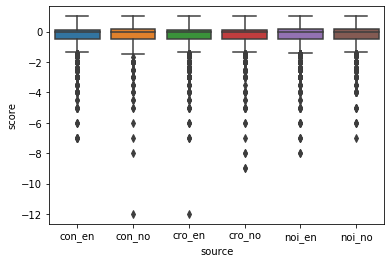

In [139]:
names = ['con_en', 'con_no', 'cro_en', 'cro_no', 'noi_en', 'noi_no']

tuples = []
for index, scores in enumerate(df_score['score']):
    for a_score in scores:
        tuples.append((names[index], float(a_score)))
        
df_boxplot = pd.DataFrame(tuples, columns=['source', 'score'])

sns.boxplot(data=df_boxplot, x='source', y='score')

plt.show()

In [152]:
video_reference_df['Lev_Test'] = lv_score(video_reference_df['transcript'], other['transcript'])

In [153]:
video_reference_df.loc[video_reference_df['Lev_Test'] < 0]

,start,end,transcript,Lev_Test
9,4.33,4.44,de,-0.500000
10,4.45,4.90,sin,-0.333333
13,5.49,5.55,de,-0.500000
14,5.55,5.69,los,-0.666667
18,6.38,6.44,de,-3.000000
...,...,...,...,...
1570,895.00,897.16,co-,-0.333333
1573,897.50,897.58,me,-2.500000
1575,897.69,897.72,a,-1.000000
1578,898.22,898.33,la,-0.500000


# Troubleshooting different Functions
I'll use the next cells for debug